In [1]:
try:
    # general data handling and preprocessing
    import time
    from copy import deepcopy
    from scipy.interpolate import make_interp_spline
    from itertools import combinations
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import (
        StandardScaler,
        LabelEncoder,
        MinMaxScaler,
        Binarizer,
    )
    from sklearn.pipeline import Pipeline
    from sklearn.utils import resample
    from sklearn.decomposition import PCA

    # visualizations
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize
    from matplotlib.cm import ScalarMappable
    import seaborn as sns
    import dhg.visualization as vis

    # statistics
    from scipy.stats import ttest_ind, pearsonr
    from sklearn.neighbors import NearestNeighbors
    from sklearn.utils.class_weight import compute_class_weight
    import statsmodels.api as sm
    from statsmodels.stats.multitest import multipletests
    from sklearn.metrics import (
        confusion_matrix,
        classification_report,
        ConfusionMatrixDisplay,
        roc_curve,
        auc,
        accuracy_score,
        f1_score,
    )

    # machine learning/neural networks/hypergraphs
    from sklearn.linear_model import (
        LinearRegression,
        Lasso,
        Ridge,
        LassoCV,
    )
    from sklearn.model_selection import (
        train_test_split,
        GridSearchCV,
        KFold,
        cross_val_score,
    )
    from sklearn.preprocessing import MinMaxScaler
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import torch.nn.functional as F
    from torch.utils.data import DataLoader, TensorDataset
    import smogn
    import networkx as nx
    import dhg
    from dhg import Hypergraph
    from dhg.data import Cooking200
    from dhg.models import HGNN, HGNNP
    from dhg.random import set_seed
    from dhg.metrics import HypergraphVertexClassificationEvaluator as Evaluator
    
    # print plot in notebook
    %matplotlib inline    

except ImportError as e:
    print(
        f"An ImportError occurred: {e}\n"
        "please ensure all required libraries are installed "
    )
    with open('../results/result.txt', 'w') as f:
        f.write(
            "an ImportError occurred; please refer to the console output"
        )

In [2]:
# load data sheet
df = pd.read_excel("../data/t1_metrics.xlsx")

# factorize the 'sex' column
df['sex_factorized'], uniques = pd.factorize(df['sex'])
# display the mapping
sex_mapping = dict(zip(uniques, range(len(uniques))))
print("Sex Mapping:", sex_mapping)

# factorize the 'Target' column
df['Target_factorized'], uniques = pd.factorize(df['Target'])
# display the mapping
target_mapping = dict(zip(uniques, range(len(uniques))))
print("Target Mapping:", target_mapping)

# factorize the 'No_Leads' column
df['No_Leads_factorized'], uniques = pd.factorize(df['No_Leads'])
# display the mapping
no_leads_mapping = dict(zip(uniques, range(len(uniques))))
print("No_Leads Mapping:", no_leads_mapping)

# factorize the 'class1' column
df['class1_factorized'], uniques = pd.factorize(df['class1'])
# Display the mapping
class1_mapping = dict(zip(uniques, range(len(uniques))))
print("Class Mapping:", class1_mapping)

# reorder columns to move 'age' and 'MDSUPDRS' to the end with other clinical variables
cols = list(df.columns)
cols.remove('age')
cols.remove('MDSUPDRS')
cols += ['age', 'MDSUPDRS']
df = df[cols]

Sex Mapping: {'M': 0, 'F': 1}
Target Mapping: {'STN': 0, 'GPi': 1}
No_Leads Mapping: {'Bi': 0, 'Uni': 1}
Class Mapping: {1: 0, 0: 1}


In [3]:
# columns not to be included in the model
drop_cols = ["class1", "PTID_Retro_Clin", "Target", "No_Leads", "group", "sex", "delta_ledd", "class1_factorized"]

X = df.drop(drop_cols, axis=1).values  # Predictors
y = df["delta_ledd"].values  # Outcome observable
class1 = df["class1"]  # Stratification variable

# stratified splitting
indices = np.arange(len(df))  
train_indices, temp_indices, y_train, y_temp = train_test_split(
    indices, y, test_size=0.3, stratify=class1, random_state=27
)
val_indices, test_indices, y_val, y_test = train_test_split(
    temp_indices, y[temp_indices], test_size=0.5, stratify=class1[temp_indices], random_state=27
)

# wxtract data for training, validation, and testing sets
X_train = X[train_indices]
X_val = X[val_indices]
X_test = X[test_indices]

# convert indices to boolean masks (for HGNN later)
train_mask_tensor = torch.zeros(len(df), dtype=torch.bool)
val_mask_tensor = torch.zeros(len(df), dtype=torch.bool)
test_mask_tensor = torch.zeros(len(df), dtype=torch.bool)

train_mask_tensor[train_indices] = True
val_mask_tensor[val_indices] = True
test_mask_tensor[test_indices] = True


In [4]:
def oversample_continuous(X, y, threshold, multiplier=2, k_neighbors=5):
    """
     oversampling for continuous observables
    Args:
        X (numpy array): feature matrix
        y (numpy array): target vector
        threshold (float): define "minority" samples based on this threshold
        multiplier (int): # of synthetic samples to create per minority sample
        k_neighbors (int): # of neighbors for interpolation
    Returns:
        X_resampled (numpy array): resampled feature matrix
        y_resampled (numpy array): resampled target vector
        minority_indices (list): indices of the minority samples in the original data
    """
    # identify minority samples
    minority_mask = y < threshold
    minority_indices = np.where(minority_mask)[0]  # Get indices of minority samples
    X_minority = X[minority_mask]
    y_minority = y[minority_mask]
    
    # find neighbors
    nbrs = NearestNeighbors(n_neighbors=k_neighbors).fit(X_minority)
    neighbors = nbrs.kneighbors(X_minority, return_distance=False)
    
    # synthetic samples
    synthetic_X = []
    synthetic_y = []
    for i in range(X_minority.shape[0]):
        for _ in range(multiplier):
            neighbor_idx = np.random.choice(neighbors[i])
            alpha = np.random.rand()
            synthetic_X.append(alpha * X_minority[i] + (1 - alpha) * X_minority[neighbor_idx])
            synthetic_y.append(alpha * y_minority[i] + (1 - alpha) * y_minority[neighbor_idx])
    
    # combine original and synthetic samples
    X_resampled = np.vstack([X, np.array(synthetic_X)])
    y_resampled = np.hstack([y, np.array(synthetic_y)])
    
    return X_resampled, y_resampled, minority_indices


X_train_resampled, y_train_resampled, minority_indices = oversample_continuous(X_train, y_train, threshold=0)

In [5]:
# copy of the original dataframe to modify
df_resampled = df.copy()

# # of synthetic samples
num_synthetic_samples = len(X_train_resampled) - len(X_train)

# create dataframe for synthetic samples
synthetic_data_features = pd.DataFrame(
    X_train_resampled[len(X_train):], 
    columns=df.drop(drop_cols, axis=1).columns  
)

# rebuild synthetic rows 
synthetic_data = pd.DataFrame(columns=df.columns) 
for col in df.columns:
    if col in synthetic_data_features.columns:
        synthetic_data[col] = synthetic_data_features[col]
    elif col == "delta_ledd":
        synthetic_data[col] = y_train_resampled[len(X_train):]
    elif col == "class1":
        synthetic_data[col] = 0
    else:
       synthetic_data[col] = None

# append synthetic data to the resampled dataframe
df_resampled = pd.concat([df_resampled, synthetic_data], ignore_index=True)

# update training mask to include new synthetic indices
new_train_indices = train_indices.tolist() + list(range(len(df), len(df_resampled)))
train_mask_tensor = torch.zeros(len(df_resampled), dtype=torch.bool)
train_mask_tensor[new_train_indices] = True

# these should be the same...
val_mask_tensor = torch.zeros(len(df_resampled), dtype=torch.bool)
val_mask_tensor[val_indices] = True
test_mask_tensor = torch.zeros(len(df_resampled), dtype=torch.bool)
test_mask_tensor[test_indices] = True


In [6]:
# factorize the 'sex' column
df_resampled['sex_factorized'], uniques = pd.factorize(df_resampled['sex'])
# display the mapping
sex_mapping = dict(zip(uniques, range(len(uniques))))
print("Sex Mapping:", sex_mapping)

# factorize the 'Target' column
df_resampled['Target_factorized'], uniques = pd.factorize(df_resampled['Target'])
# display the mapping
target_mapping = dict(zip(uniques, range(len(uniques))))
print("Target Mapping:", target_mapping)

# factorize the 'No_Leads' column
df_resampled['No_Leads_factorized'], uniques = pd.factorize(df_resampled['No_Leads'])
# display the mapping
no_leads_mapping = dict(zip(uniques, range(len(uniques))))
print("No_Leads Mapping:", no_leads_mapping)

# factorize the 'class1' column
df_resampled['class1_factorized'], uniques = pd.factorize(df_resampled['class1'])
# Display the mapping
class1_mapping = dict(zip(uniques, range(len(uniques))))
print("Class Mapping:", class1_mapping)

# reorder columns to move 'age' and 'MDSUPDRS' to the end with other clinical variables
cols = list(df_resampled.columns)
cols.remove('age')
cols.remove('MDSUPDRS')
cols += ['age', 'MDSUPDRS']
df_resampled = df_resampled[cols]

drop_cols = ["class1", "PTID_Retro_Clin", "Target", "No_Leads", "group", "sex", "delta_ledd", "class1_factorized"]
X = torch.tensor(df_resampled.drop(drop_cols, axis=1).values, dtype=torch.float32)  
y = torch.tensor(df_resampled["delta_ledd"].values, dtype=torch.float32)  # Outcome observable
class1 = torch.tensor(df_resampled["class1"].values, dtype=torch.long)  # Stratification variable

# X_train and y_train based on train_mask_tensor
X_train = X[train_mask_tensor]
y_train = y[train_mask_tensor]


Sex Mapping: {'M': 0, 'F': 1}
Target Mapping: {'STN': 0, 'GPi': 1}
No_Leads Mapping: {'Bi': 0, 'Uni': 1}
Class Mapping: {1: 0, 0: 1}


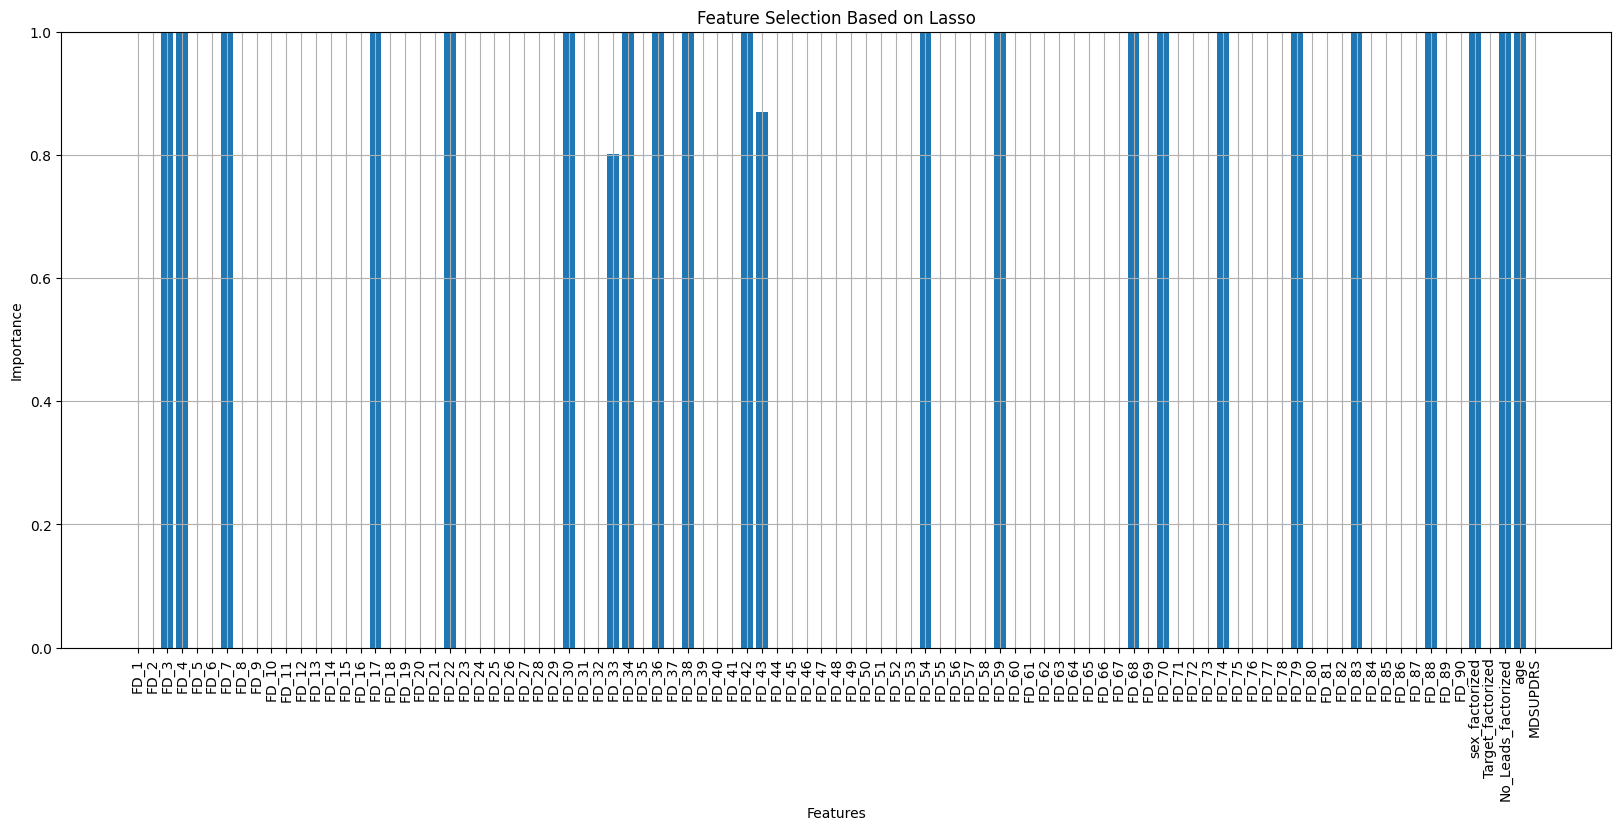

Selected Feature Columns: ['FD_3' 'FD_4' 'FD_7' 'FD_17' 'FD_22' 'FD_30' 'FD_33' 'FD_34' 'FD_36'
 'FD_38' 'FD_42' 'FD_43' 'FD_54' 'FD_59' 'FD_68' 'FD_70' 'FD_74' 'FD_79'
 'FD_83' 'FD_88' 'sex_factorized' 'No_Leads_factorized' 'age']
Number of Selected Features: 23


In [7]:
# normalize data to make sure nothing is dominating. can do standard or minmax or whatever else
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Scale the resampled training data

# LASSO regression model 
lasso_model = Lasso(alpha=0.59) # optimize and adjust shrinkage factor appropriately
lasso_model.fit(X_train_scaled, y_train)  
lasso_coef = lasso_model.coef_

# extract feature names
names = df.drop(drop_cols, axis=1).columns

# absolute values of LASSO coefficients
lasso1_coef = np.abs(lasso_coef)

%matplotlib inline

# plot
plt.figure(figsize=(20, 8))
plt.bar(names, lasso1_coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.ylim(0, 1)
plt.show() 

# subset features with importance greater than 0.002
feature_subset_low = np.array(names)[lasso1_coef > 0.002]
print("Selected Feature Columns: {}".format(feature_subset_low))
print("Number of Selected Features: {}".format(len(feature_subset_low)))


In [8]:
# extract feature indices corresponding to the selected features
significant_feature_indices = [np.where(names == feature)[0][0] for feature in feature_subset_low]

# check validity of indices
if not all(idx < len(names) for idx in significant_feature_indices):
    print("Warning: Some significant feature indices exceed the number of available features!")

# custom labels
custom_labels = [
    "Precentral L", "Precentral R", "Frontal Sup L", "Frontal Sup R", "Frontal Sup Orb L", "Frontal Sup Orb R",  # 1-6
    "Frontal Mid L", "Frontal Mid R", "Frontal Mid Orb L", "Frontal Mid Orb R", "Frontal Mid Inf L", "Frontal Mid Inf R",  # 7-12
    "Frontal Inf Tri L", "Frontal Inf Tri R", "Frontal Inf Orb L", "Frontal Inf Orb R", "Rolandic Oper L", "Rolandic Oper R",  # 13-18
    "Supp Motor Area L", "Supp Motor Area R", "Olfactory L", "Olfactory R", "Frontal Sup Medial L", "Frontal Sup Medial R",  # 19-24
    "Frontal Med Orb L", "Frontal Med Orb R", "Rectus L", "Rectus R", "Insula L", "Insula R",  # 25-30
    "Cingulum Ant L", "Cingulum Ant R", "Cingulum Mid L", "Cingulum Mid R", "Cingulum Post L", "Cingulum Post R",  # 31-36
    "Hippocampus L", "Hippocampus R", "ParaHippocampal L", "ParaHippocampal R", "Amygdala L", "Amygdala R",  # 37-42
    "Calcarine L", "Calcarine R", "Cuneus L", "Cuneus R", "Lingual L", "Lingual R",  # 43-48
    "Occipital Sup L", "Occipital Sup R", "Occipital Mid L", "Occipital Mid R", "Occipital Inf L", "Occipital Inf R",  # 49-54
    "Fusiform L", "Fusiform R", "Postcentral L", "Postcentral R", "Parietal Sup L", "Parietal Sup R",  # 55-60
    "Parietal Inf L", "Parietal Inf R", "SupraMarginal L", "SupraMarginal R", "Angular L", "Angular R",  # 61-66
    "Precuneus L", "Precuneus R", "Paracentral Lobule L", "Paracentral Lobule R", "Caudate L", "Caudate R",  # 67-72
    "Putamen L", "Putamen R", "Pallidum L", "Pallidum R", "Thalamus L", "Thalamus R",  # 73-78
    "Heschl L", "Heschl R", "Temporal Sup L", "Temporal Sup R", "Temporal Pole Sup L", "Temporal Pole Sup R",  # 79-84
    "Temporal Mid L", "Temporal Mid R", "Temporal Pole Mid L", "Temporal Pole Mid R", "Temporal Inf L", "Temporal Inf R",  # 85-90
    "Sex", "DBS Target", "Lead Configuration", "Age", "MDS-UPDRS III"
]

# labels for significant features
significant_features_custom_labels = [custom_labels[index] for index in significant_feature_indices]
print("Significant Features with Custom Labels: {}".format(significant_features_custom_labels))

X_significant = X_train_scaled[:, significant_feature_indices]


Significant Features with Custom Labels: ['Frontal Sup L', 'Frontal Sup R', 'Frontal Mid L', 'Rolandic Oper L', 'Olfactory R', 'Insula R', 'Cingulum Mid L', 'Cingulum Mid R', 'Cingulum Post R', 'Hippocampus R', 'Amygdala R', 'Calcarine L', 'Occipital Inf R', 'Parietal Sup L', 'Precuneus R', 'Paracentral Lobule R', 'Putamen R', 'Heschl L', 'Temporal Pole Sup L', 'Temporal Pole Mid R', 'Sex', 'Lead Configuration', 'Age']


                 Feature  Ridge Coefficient  Normalized Ridge Coefficient  \
0          Frontal Sup L          24.380870                      0.889767   
1          Frontal Sup R          26.154440                      0.942016   
2          Frontal Mid L         -26.822800                     -0.618687   
3        Rolandic Oper L         -39.741143                     -0.999260   
4            Olfactory R         -20.566580                     -0.434380   
5               Insula R         -15.350469                     -0.280714   
6         Cingulum Mid L          17.252349                      0.679762   
7         Cingulum Mid R         -12.641602                     -0.200911   
8        Cingulum Post R          19.108455                      0.734442   
9          Hippocampus R         -33.037170                     -0.801762   
10            Amygdala R          18.969735                      0.730356   
11           Calcarine L         -28.416573                     -0.665640   

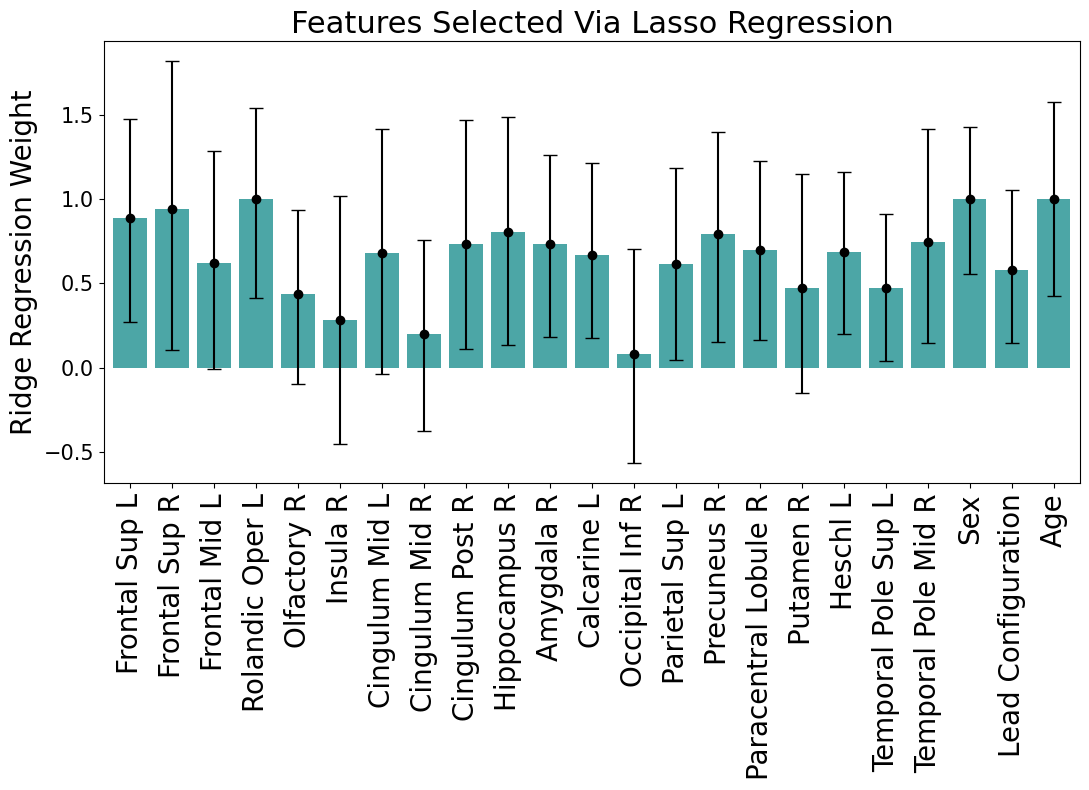

In [9]:
# ridge regression with bootstrapping for CIs
ridge_model = Ridge(alpha=0.9)
n_iterations = 1000
n_size = X_train_scaled.shape[0]
ridge_coef_bootstrap = np.zeros((n_iterations, len(significant_feature_indices)))

# bootstrapping
for i in range(n_iterations):
    X_train_resample, y_train_resample = resample(
        X_train_scaled[:, significant_feature_indices], y_train, n_samples=n_size, random_state=i
    )
    ridge_model.fit(X_train_resample, y_train_resample)
    ridge_coef_bootstrap[i, :] = ridge_model.coef_

# mean and 95% CIs for the coefficients
ridge_coef_mean = np.mean(ridge_coef_bootstrap, axis=0)
ridge_coef_lower = np.percentile(ridge_coef_bootstrap, 2.5, axis=0)
ridge_coef_upper = np.percentile(ridge_coef_bootstrap, 97.5, axis=0)

# normalize the ridge coefficients 
scaler = MinMaxScaler(feature_range=(-1, 1))
normalized_ridge_coef_mean = scaler.fit_transform(ridge_coef_mean.reshape(-1, 1)).flatten()
normalized_ridge_coef_lower = scaler.transform(ridge_coef_lower.reshape(-1, 1)).flatten()
normalized_ridge_coef_upper = scaler.transform(ridge_coef_upper.reshape(-1, 1)).flatten()

# display results 
ridge_results = pd.DataFrame({
    'Feature': significant_features_custom_labels,
    'Ridge Coefficient': ridge_coef_mean,
    'Normalized Ridge Coefficient': normalized_ridge_coef_mean,
    'Lower CI': normalized_ridge_coef_lower,
    'Upper CI': normalized_ridge_coef_upper
})

print(ridge_results)

# plot 
plt.figure(figsize=(11, 8))
bars = plt.bar(
    ridge_results['Feature'],
    np.abs(ridge_results['Normalized Ridge Coefficient']),
    color='teal',
    alpha=0.7,
)
plt.errorbar(
    ridge_results['Feature'],
    np.abs(ridge_results['Normalized Ridge Coefficient']),
    yerr=[
        np.abs(ridge_results['Normalized Ridge Coefficient'] - ridge_results['Lower CI']),
        np.abs(ridge_results['Upper CI'] - ridge_results['Normalized Ridge Coefficient']),
    ],
    fmt='o',
    color='black',
    capsize=5,
)
plt.title("Features Selected Via Lasso Regression", fontsize=22)
plt.xlabel("", fontsize=18)
plt.ylabel("Ridge Regression Weight", fontsize=20)

# Set the x-tick labels to the actual region names
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.gca().margins(x=0.01)
plt.savefig("../results/feature_select.png", bbox_inches='tight') # adjust title of image
plt.show()

In [10]:
# unique values
unique_class1_values = df_resampled["class1"].unique()
print(f"Adjusted Unique 'class1' Values: {unique_class1_values}")

# number of 1s and 0s in the class1 column
class1_counts = df_resampled["class1"].value_counts()

# print the counts
print(f"Number of 1s: {class1_counts.get(1, 0)}")
print(f"Number of 0s: {class1_counts.get(0, 0)}")

normalized_ridge_coef = ridge_results['Normalized Ridge Coefficient']
# dictionary to map features to their normalized ridge coefficient
feature_to_coef = dict(zip(significant_features_custom_labels, normalized_ridge_coef))

print(feature_to_coef)


Adjusted Unique 'class1' Values: [1 0]
Number of 1s: 171
Number of 0s: 117
{'Frontal Sup L': 0.8897669531367948, 'Frontal Sup R': 0.9420161067446994, 'Frontal Mid L': -0.6186872423050293, 'Rolandic Oper L': -0.9992601323970551, 'Olfactory R': -0.434379731508458, 'Insula R': -0.2807137045697119, 'Cingulum Mid L': 0.6797615360379623, 'Cingulum Mid R': -0.2009107929138182, 'Cingulum Post R': 0.7344422057025203, 'Hippocampus R': -0.8017618807553891, 'Amygdala R': 0.7303555442835835, 'Calcarine L': -0.66563960335077, 'Occipital Inf R': -0.08199327806946471, 'Parietal Sup L': -0.613151045597094, 'Precuneus R': -0.7900620439613661, 'Paracentral Lobule R': 0.6984833186654524, 'Putamen R': -0.47050262816121313, 'Heschl L': 0.6871565921598962, 'Temporal Pole Sup L': 0.472757487099668, 'Temporal Pole Mid R': 0.7467274515396212, 'Sex': 1.0, 'Lead Configuration': 0.5781944932958641, 'Age': -1.0}


In [11]:
from dhg import Hypergraph

k = 4  # k-nearest neighbors for continuous features; optimize

# # of vertices
num_v = X.shape[0]  

# 1) Target (Categorical)
data_1_temp = X[:, names.tolist().index('Target_factorized')]
gpi_indices = [i for i, val in enumerate(data_1_temp) if val == 1]
stn_indices = [i for i, val in enumerate(data_1_temp) if val == 0]
e_list = [stn_indices, gpi_indices]
e_weight = [1.0, 1.0]
v_weight = [1.0] * num_v
hg_1 = Hypergraph(num_v=num_v, e_list=e_list, e_weight=e_weight, v_weight=v_weight)
hg_1.e_weight = [feature_to_coef.get('DBS Target', 1.0)] * hg_1.num_e

# 2) Age (Continuous)
data_age = X[:, names.tolist().index('age')].reshape(-1, 1).clone().detach()
hg_2 = Hypergraph.from_feature_kNN(data_age, k)
hg_2.e_weight = [feature_to_coef.get('Age', 1.0)] * hg_2.num_e

# 3) No_Leads (Categorical)
data_3_temp = X[:, names.tolist().index('No_Leads_factorized')]
bi_indices = [i for i, val in enumerate(data_3_temp) if val == 0]
uni_indices = [i for i, val in enumerate(data_3_temp) if val == 1]
e_list = [bi_indices, uni_indices]
e_weight = [1.0, 1.0]
hg_3 = Hypergraph(num_v=num_v, e_list=e_list, e_weight=e_weight, v_weight=v_weight)
hg_3.e_weight = [feature_to_coef.get('Lead Configuration', 1.0)] * hg_3.num_e

# 4) Pre-Op MDSUPDRS (Continuous)
data_mds_updrs = X[:, names.tolist().index('MDSUPDRS')].reshape(-1, 1).clone().detach()
hg_4 = Hypergraph.from_feature_kNN(data_mds_updrs, k)
hg_4.e_weight = [feature_to_coef.get('MDS-UPDRS III', 1.0)] * hg_4.num_e

# 5) Sex (Categorical)
data_sex = X[:, names.tolist().index('sex_factorized')]
m_indices = [i for i, val in enumerate(data_sex) if val == 0]
f_indices = [i for i, val in enumerate(data_sex) if val == 1]
e_list = [m_indices, f_indices]
hg_5 = Hypergraph(num_v=num_v, e_list=e_list, e_weight=e_weight, v_weight=v_weight)
hg_5.e_weight = [feature_to_coef.get('Sex', 0.05)] * hg_5.num_e

In [12]:
# map from custom labels to feature names
custom_label_to_feature = {custom_labels[i]: f"FD_{i+1}" for i in range(len(custom_labels))}

# significant feature indices (from Lasso)
significant_feature_indices = [np.where(names == feature)[0][0] for feature in feature_subset_low]

# filter out clinical features
region_features_indices = [
    idx for idx in significant_feature_indices
    if names[idx] not in ["Sex", "MDSUPDRS", "DBS Target", "Target_factorized",
                          "sex_factorized", "Lead Configuration", "No_Leads_factorized", "age", "Age", "MDS-UPDRS III"]
]

# generate hypergraphs for FD features
hypergraphs = {}
for i, idx in enumerate(region_features_indices):
    feature_name = names[idx]  # Feature column name
    feature_label = custom_label_to_feature.get(feature_name, feature_name)  # Custom label mapping

    data = X[:, idx].reshape(-1, 1).clone().detach() 
    hg = Hypergraph.from_feature_kNN(data, k)

    hg.e_weight = [feature_to_coef.get(feature_label, 1.0)] * hg.num_e

    hypergraphs[feature_label] = hg

#  summary
print(f"Generated {len(hypergraphs)} hypergraphs:")
for label, hg in hypergraphs.items():
    print(f" - {label}: {hg.num_e} edges, {hg.num_v} vertices")

Generated 20 hypergraphs:
 - FD_3: 152 edges, 288 vertices
 - FD_4: 155 edges, 288 vertices
 - FD_7: 159 edges, 288 vertices
 - FD_17: 157 edges, 288 vertices
 - FD_22: 169 edges, 288 vertices
 - FD_30: 152 edges, 288 vertices
 - FD_33: 150 edges, 288 vertices
 - FD_34: 160 edges, 288 vertices
 - FD_36: 149 edges, 288 vertices
 - FD_38: 155 edges, 288 vertices
 - FD_42: 148 edges, 288 vertices
 - FD_43: 150 edges, 288 vertices
 - FD_54: 147 edges, 288 vertices
 - FD_59: 160 edges, 288 vertices
 - FD_68: 148 edges, 288 vertices
 - FD_70: 160 edges, 288 vertices
 - FD_74: 152 edges, 288 vertices
 - FD_79: 167 edges, 288 vertices
 - FD_83: 152 edges, 288 vertices
 - FD_88: 149 edges, 288 vertices


In [13]:
# clinical hypergraphs (hg_1 to hg_5)
clinical_hypergraphs = [hg_1, hg_2, hg_3, hg_4, hg_5]

# imaging hypergraphs from the previous step
imaging_hypergraphs = list(hypergraphs.values())  

# combine clinical hypergraphs
clin = clinical_hypergraphs[0]
for hg in clinical_hypergraphs[1:]:
    if hg.num_v != clin.num_v:
        raise ValueError("Mismatch in the number of vertices between clinical hypergraphs!")
    clin.add_hyperedges_from_graph(hg)

# combine imaging hypergraphs
imag = imaging_hypergraphs[0]
for hg in imaging_hypergraphs[1:]:
    if hg.num_v != imag.num_v:
        raise ValueError("Mismatch in the number of vertices between imaging hypergraphs!")
    imag.add_hyperedges_from_graph(hg)

# combine clinical and imaging hypergraphs into a total hypergraph
total = imag
if clin.num_v != total.num_v:
    raise ValueError("Mismatch in the number of vertices between clinical and imaging hypergraphs!")
total.add_hyperedges_from_graph(clin)

# results
print(f"Clinical Hypergraph: {clin.num_e} edges, {clin.num_v} vertices")
print(f"Imaging Hypergraph: {imag.num_e} edges, {imag.num_v} vertices")
print(f"Total Hypergraph: {total.num_e} edges, {total.num_v} vertices")

Clinical Hypergraph: 302 edges, 288 vertices
Imaging Hypergraph: 3390 edges, 288 vertices
Total Hypergraph: 3390 edges, 288 vertices


In [14]:
# Cross-Entropy Loss Function
def cross_entropy_loss(outputs, labels):
    return F.cross_entropy(outputs, labels)

# training function
def train(net, X, hg, lbls, train_idx, optimizer):
    net.train()
    optimizer.zero_grad()

    # forward pass
    outs = net(X, hg)

    # only consider training indices
    outs_train, lbls_train = outs[train_idx], lbls[train_idx]

    # compute loss
    if len(lbls_train) > 0:
        loss = cross_entropy_loss(outs_train, lbls_train)
        loss.backward()
        optimizer.step()
    else:
        loss = torch.tensor(0.0, requires_grad=True)

    return loss.item()

# infer function
@torch.no_grad()
def infer(net, X, hg, lbls, idx, evaluator, test=False):
    net.eval()

    # forward pass
    outs = net(X, hg)

    # only consider the indices for validation/testing
    outs_idx, lbls_idx = outs[idx], lbls[idx]

    if len(lbls_idx) == 0 or len(outs_idx) == 0:
        return {}, None, None

    # predicted labels
    _, preds = torch.max(outs_idx, dim=1)

    # evaluation
    res = evaluator.validate(lbls_idx, outs_idx) if not test else evaluator.test(lbls_idx, outs_idx)

    return res, preds, lbls_idx



def set_seed(seed: int):
    """
    Set the seed for random number generators in Python, NumPy, and PyTorch for reproducibility.
    Args:
        seed (int): The seed value to use.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [18]:
import random
from dhg import Hypergraph
from dhg.data import Cooking200
from dhg.models import HGNN, HGNNP
from dhg.random import set_seed
from dhg.metrics import HypergraphVertexClassificationEvaluator as Evaluator

hg = total
class1 = torch.tensor(df_resampled["class1"].values, dtype=torch.long)  # Stratification variable


# main training and testing
if __name__ == "__main__":
    set_seed(2020)
    device = torch.device("cpu")
    evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])

    lbl = class1
    

    net = HGNN(X.shape[1], 32, 2, use_bn=False)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=5e-4)

    # initialize variables for best model tracking
    best_state = deepcopy(net.state_dict())
    best_epoch, best_val = 0, 0

    for epoch in range(1500):
        # Train the model
        train_loss = train(net, X, hg, lbl, train_mask_tensor, optimizer)
        
        # validate model
        with torch.no_grad():
            val_res, _, _ = infer(net, X, hg, lbl, val_mask_tensor, evaluator)
        val_accuracy = val_res.get('accuracy', 0) if isinstance(val_res, dict) else val_res

        # update the best model if validation accuracy improves
        if val_accuracy > best_val:
            best_epoch = epoch
            best_val = val_accuracy
            best_state = deepcopy(net.state_dict())

    # best model state
    net.load_state_dict(best_state)

    # test model
    test_res, _, _ = infer(net, X, hg, lbl, test_mask_tensor, evaluator, test=True)

    # final results
    print("\nFinal Test Results:")
    print(f"Accuracy: {test_res.get('accuracy', 0):.4f}")
    print(f"F1 Score: {test_res.get('f1_score', 0):.4f}")

# write results to a text file
    output_file = "../results/classification_results.txt"
    with open(output_file, "w") as f:
        accuracy = float(test_res.get('accuracy', 0))
        f1_score = float(test_res.get('f1_score', 0))

        # Write formatted results
        f.write("Final Test Results:\n")
        f.write(f"Accuracy: {accuracy:.4f}\n")
        f.write(f"F1 Score: {f1_score:.4f}\n")

    print(f"Results saved to {output_file}")


Final Test Results:
Accuracy: 0.7879
F1 Score: 0.4407
Results saved to ../results/classification_results.txt


In [19]:
# define the columns for clinical features and fractal dimensions
clinical_features_cols = ['Target_factorized', 'No_Leads_factorized', 'age', 'sex_factorized', 'MDSUPDRS']
selected_features = feature_subset_low  
fractal_dimensions_cols = [col for col in selected_features if col.startswith('FD_')]

# dependent variable
y = df["delta_ledd"].values

# model 1: clinical features only
X1 = sm.add_constant(df[clinical_features_cols])
model1 = sm.OLS(y, X1).fit()

# model 2: clinical features + fractal dimensions
X2 = sm.add_constant(df[clinical_features_cols + fractal_dimensions_cols])
model2 = sm.OLS(y, X2).fit()

# R-squared values
R2_model1 = model1.rsquared
R2_model2 = model2.rsquared

# calculate additional variance explained by fractal dimensions
additional_variance_explained = R2_model2 - R2_model1

# f-test to determine significance of the additional variance
f_test_stat, p_value, df_diff = model2.compare_f_test(model1)

# results
print(f"R-squared for model 1 (clinical features only): {R2_model1}")
print(f"R-squared for model 2 (clinical features + fractal dimensions): {R2_model2}")
print(f"additional variance explained by fractal dimensions: {additional_variance_explained}")
print(f"F-test statistic: {f_test_stat}")
print(f"p-value: {p_value}")
print(f"degrees of freedom difference: {df_diff}")

# model summaries
print("\nmodel 1 summary (clinical features only):")
print(model1.summary())
print("\nmodel 2 summary (clinical features + fractal dimensions):")
print(model2.summary())

# Prepare results as a string
results = f"""
Model Comparison Results:

R-squared for Model 1 (Clinical features only): {R2_model1:.4f}
R-squared for Model 2 (Clinical + Fractal Dimensions): {R2_model2:.4f}
Additional variance explained by fractal dimensions: {additional_variance_explained:.4f}

F-test Results:
F-test statistic: {f_test_stat:.4f}
p-value: {p_value:.4f}
Degrees of freedom difference: {df_diff}

Model 1 Summary (Clinical Features Only):
{model1.summary()}

Model 2 Summary (Clinical + Fractal Dimensions):
{model2.summary()}
"""

# Output results to a text file
output_path = "../results/model_comparison_results.txt"
with open(output_path, "w") as f:
    f.write(results)

print(f"Results saved to {output_path}")

R-squared for model 1 (clinical features only): 0.25160221848456776
R-squared for model 2 (clinical features + fractal dimensions): 0.38960269938834946
additional variance explained by fractal dimensions: 0.1380004809037817
F-test statistic: 2.193005544790792
p-value: 0.003379447688953099
degrees of freedom difference: 20.0

model 1 summary (clinical features only):
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     14.39
Date:                Wed, 04 Dec 2024   Prob (F-statistic):           3.79e-12
Time:                        20:42:30   Log-Likelihood:                -1070.6
No. Observations:                 220   AIC:                             2153.
Df Residuals:                     214   BIC:                             2174.